In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import entropy
import json
from helpers import style
from helpers.afa import adaptive_filter
from tqdm import tqdm
from collections import Counter
import networkx as nx

from helpers.linkage import mutual_information_smooth
from helpers.pathtools import *
from helpers.metrics import *
from helpers.visuals import add_cabinet_periods

lda_path = '/home/rb/Documents/Data/models/lda/postwar-v3/'

style.load_style()

from helpers.dataloader import load

In [3]:
dists, dat, _, keys = load(zscore_filter=False)

In [4]:
networks = {}
size_dicts = {}

for cd,(date, _) in enumerate(dists.groupby(dists.index)):
    rij, ri, m = mutual_information_smooth(theta = _.to_numpy())
    rij = pd.DataFrame(rij, index=[keys[int(i)] for i in _.columns], columns=[keys[int(i)] for i in _.columns])
    rij = rij.stack().reset_index().rename(columns={"level_0":"s","level_1":"t",0:"pmi"})
    rij = rij[(rij.s != rij.t) & (rij.pmi > 0)]

    sizes = _.mean()
    sizes.index = sizes.index.astype(int).map(keys)
    sizes = sizes.to_dict()
    g = nx.from_pandas_edgelist(df = rij, source='s', target='t', edge_attr=['pmi'])
    networks[date] = g
    size_dicts[cd] = list(sizes.items())

In [5]:
# for _ in np.arange(2.5,4.5,.25):
#     tc, g, sizes, paths, metadata = get_tc(networks, size_dicts, overlap_threshold=.5, louvain_res=_,verbose=False)
#     plot_flows(g, tc, paths, networks, sizes, cmap='hsv',figsize=(100,20),save=f'figs/chains-{_}.pdf')

In [6]:
tc, g, sizes, paths, metadata = get_tc(networks, size_dicts, overlap_threshold=.5, louvain_res=3,verbose=False)

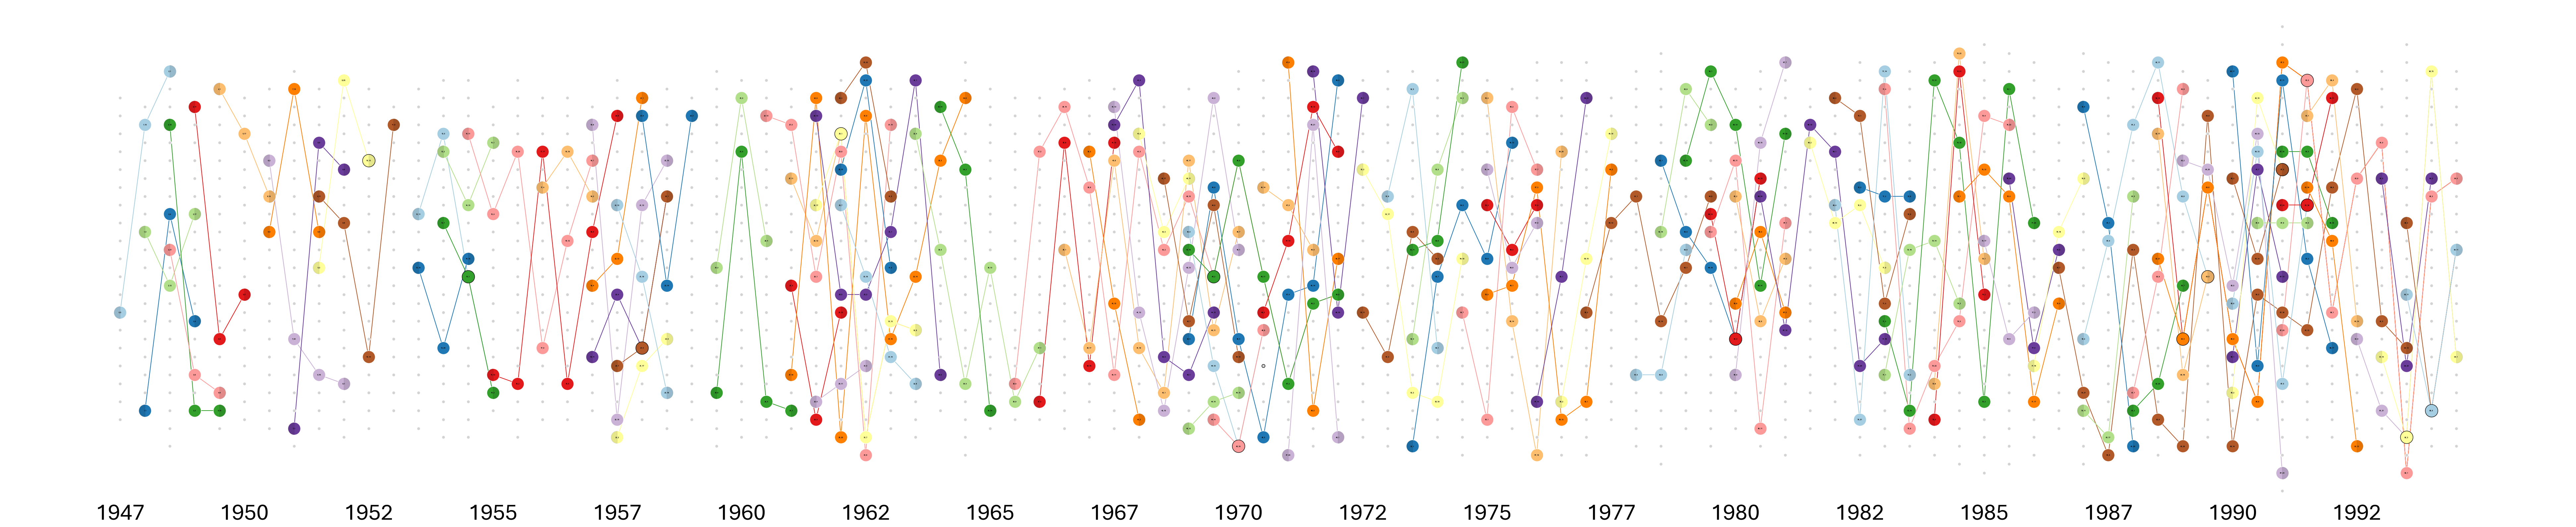

In [9]:
plot_flows(g, tc, paths, networks, sizes, annotate_max_topic=False, cmap='Paired',figsize=(100,20),save=f'figs/chains.png')

In [9]:
dists_dia = dists.groupby(dists.index).mean().rolling(4,center=True).mean().rename(columns={k:keys.get(int(k)) for k in dists.columns})

In [36]:
r = []
for c,p in enumerate(paths):
    tip = set([item for items in p for item in tc.get_community(items)])
    crr = np.mean(dists_dia[list(tip)].dropna().corr().to_numpy())
    key = ', '.join([k for k,v in Counter([item for items in p for item in tc.get_community(items)]).most_common(3)])
    if len(p)>6:
        r.append({"i":c,"crr":crr,'key':key,'l':len(p)})

In [37]:
pd.DataFrame(r).sort_values('crr',ascending=False).head(30)

i       crr                                                key   l
2   46  0.092475  education, secondary education, special educat...  15
1   38  0.086063  municipal restructuring, municipal restructuri...   7
8  111  0.077845  development aid, international conflict, devel...   8
3   48  0.070322  municipal restructuring, municipal restructuri...   7
7  109  0.061367  international interventions, nuclear arms, for...   8
5   76  0.057476  special education 1, secondary education, spec...   9
4   70  0.041300                 inflation, employment, budget cuts   7
6  103  0.031108             public housing 1, rents, rent increase  12
0   31  0.027686  international interventions, foreign relations...   7

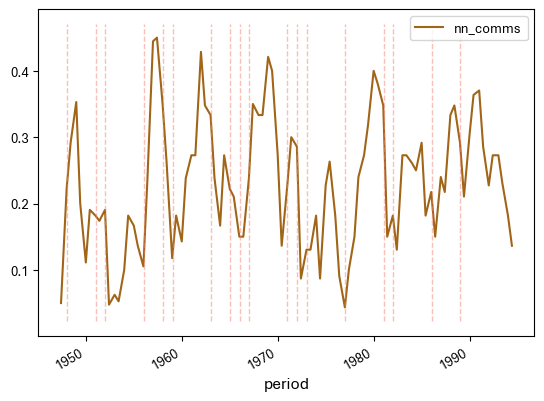

In [8]:
f,a = plt.subplots()

coverage(tc,paths,networks).plot(x='period',y='nn_comms',ax=a)
add_cabinet_periods(ax=a,min_time=1948,max_time=1994,text=False)

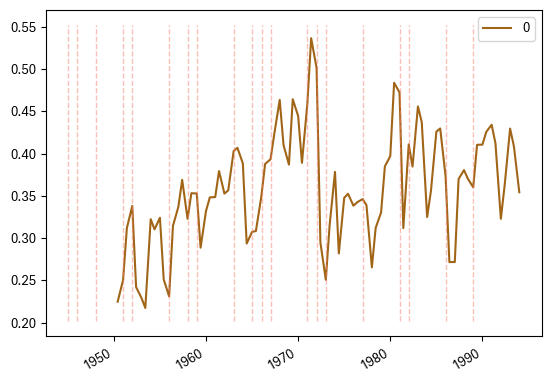

In [9]:
## New Topics in Chains

tc, g, sizes, paths, metadata = get_tc(networks, size_dicts, overlap_threshold=.5, louvain_res=3,verbose=False)
chain_ccs = [item for items in paths for item in items]

topics_in_chain = {}

for i in tc.get_observation_ids():
    path_comms = [c for c in chain_ccs if c.split('_')[0] == str(i)]
    tic = [item for items in path_comms for item in tc.get_community(items)]
    topics_in_chain[i] = set(tic)

f,a = plt.subplots()
wd = 6
ixs = sorted(networks.keys())[wd:-1]
pd.DataFrame([np.mean([jaccard_similarity(topics_in_chain[i-_],topics_in_chain[i]) for _ in range(wd)]) for i in range(wd,94)],index=ixs).plot(ax=a)
add_cabinet_periods(ax=a,min_time=1945,max_time=1994,text=False)

In [10]:
# # Look back at the previous four period and calculate mean overlap
# ps = sorted(rd.p1.unique())
# rdt=rd[rd.p1.apply(lambda per: ps.index(per)) == rd.p2.apply(lambda per: ps.index(per)) - 1]

# rr = []
# window = 4
# for t,d in rdt.groupby('t'):
#     vls = d.ovl.tolist()
#     dts = pd.to_datetime(d.p1,infer_datetime_format=True).tolist()
#     for i in range(window,len(d)):
#         lb = np.mean(vls[i-window:i])
#         rr.append({"t":t,"d":dts[i],"lbv":lb})
# rrd = pd.DataFrame(rr)
# rrd = rrd[pd.to_datetime(rrd.d,infer_datetime_format=True) < pd.Timestamp(year=1994,month=6,day=1)]

## Chain Stats

In [ ]:
path_topics = {i:pd.DataFrame([item for items in p for item in tc.get_community(items)],columns=['topic']).value_counts() for i,p in enumerate(paths)}
pdf = pd.DataFrame({i:p.max() for i,p in path_topics.items()}.items(),columns=['path_id','max']).sort_values('max',ascending=False)
pdf['topics'] = pdf.path_id.apply(lambda i:', '.join(path_topics[i].reset_index().topic[:4]))
pdf['len'] = pdf.path_id.apply(lambda i: len(paths[i]))
pdf['max_topic_persistence'] = pdf['max'] / pdf['len']
pdf['mean_topic_persistence'] = pdf.path_id.apply(lambda i:np.mean(path_topics[i] / pdf['len'][i]))

In [ ]:
target_paths = [i for c,i in enumerate(paths) if c in pdf[pdf.topics.str.contains('educ')].path_id.tolist()]
plot_flows(g, tc, target_paths, networks, sizes, cmap='hsv',figsize=(50,10),save='figs/chain-education.pdf')

In [ ]:
target_paths = [i for c,i in enumerate(paths) if c in pdf[pdf.topics.str.contains('foreign')].path_id.tolist()]
plot_flows(g, tc, target_paths, networks, sizes, cmap='hsv',figsize=(50,10),save='figs/chain-foreign.pdf')

## 

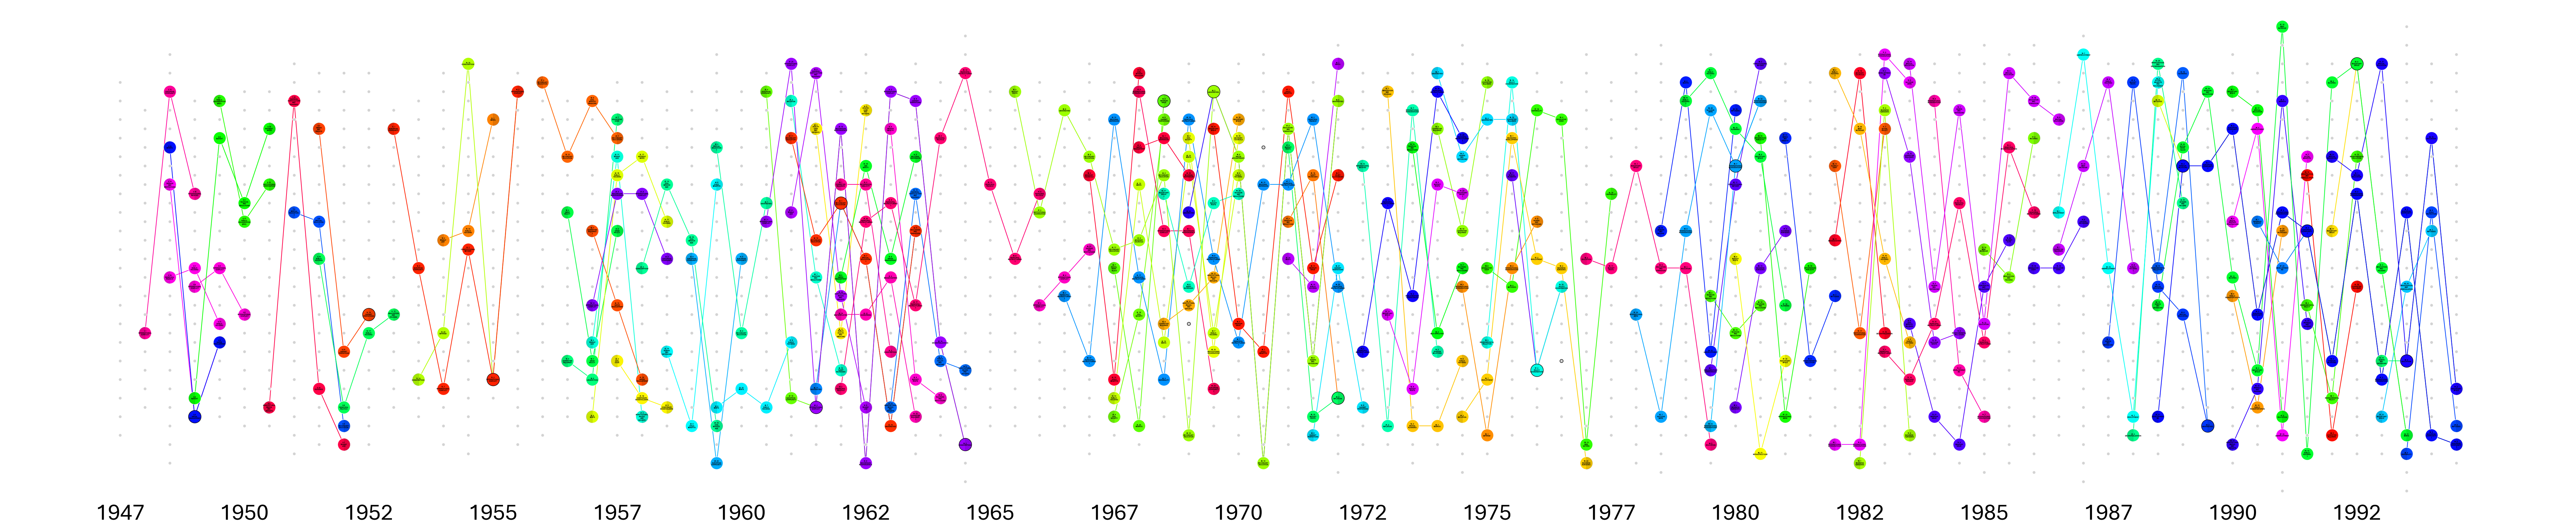

In [13]:
tc, g, sizes, paths, metadata = get_tc(networks, size_dicts, overlap_threshold=.5, louvain_res=3,verbose=False)
plot_flows(g, tc, paths, networks, sizes, cmap='hsv',figsize=(100,20),save=f'figs/chains.pdf')

In [29]:
sizes[37][3]

'institutional cooperation'

In [31]:
'\n\n'.join(['\n\t'.join([c + ':: ' + ', '.join(tc.get_community(c)) for c in p]) for p in paths if abs(int(p[0].split('_')[0]) - 40) < 5])

'36_0:: special education 1, special education, education, budget cuts, budget posts, education and formation, secondary education, budget, study allowances, universities, budgetary space 1, renovation and housing\n\t37_3:: child protection, education and formation, secondary education, public organization (pbo), special education 1, education, study allowances, institutional cooperation, vocational training\n\t38_6:: child protection, education, special education 1, education and formation, emancipation and discriminiation, secondary education, study allowances, universities, vocational training\n\t39_8:: study allowances, education and formation, secondary education, special education 1, education, vocational training, special education\n\t40_11:: secondary education, universities, special education 1, education, study allowances, labor time\n\t41_0:: child protection, education, study allowances, education and formation, secondary education, age limits, special education 1, advisory

In [14]:
tc.get_community('43_1')

['international treaties',
 'international arms',
 'defense',
 'international conflict',
 'international interventions',
 'european community',
 'indonesian independence',
 'nuclear arms',
 'european community 1',
 'science policy',
 'foreign relations']